In [672]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
import spacy
import spacy
import re

## Pré-processamento

In [673]:
df = pd.read_csv('factnews_dataset.csv')

#criar grupo treino e teste
train_df, test_df = train_test_split(df, test_size=0.7, random_state=42)

stop_words = set(stopwords.words('portuguese'))

#criar coluna tokens
train_df['tokens'] = train_df['sentences'].apply(lambda x: nltk.word_tokenize(str(x).lower()))

# Tokenizar sem stopwords
train_df['tokens'] = train_df['tokens'].apply(lambda toks: [t for t in toks if t not in stop_words])

## Análise exploratória

Detetar palavras únicas entre as classes

In [674]:
classes = df['classe'].unique()

def palavras_unicas_por_classe(df, token_col):
    
    # contar tokens por classe
    tokens_por_classe = {}
    for classe in classes:
        linhas_classe = df[df['classe'] == classe][token_col].dropna()
        contagem = {}
        for lista in linhas_classe:
            for token in lista:
                if token in contagem:
                    contagem[token] += 1
                else:
                    contagem[token] = 1
        tokens_por_classe[classe] = contagem

    # detetar palavras exclusivas por classe
    palavras_unicas = {}
    for classe in classes:
        # lista de palavras das outras classes
        outras_palavras = []
        for outra_classe in classes:
            if outra_classe != classe:
                for token in tokens_por_classe[outra_classe]:
                    outras_palavras.append(token)

        # dicionário palavras exclusivas com contagens
        unicas_classe = {}
        for palavra, contagem in tokens_por_classe[classe].items():
            exclusiva = True
            for p in outras_palavras:
                if p == palavra:
                    exclusiva = False
                    break
            if exclusiva:
                unicas_classe[palavra] = contagem

        palavras_unicas[classe] = unicas_classe

        #manter as 10 mais comuns em cada classe
        ordenadas = dict(sorted(unicas_classe.items(), key=lambda item: item[1], reverse=True)[:10])

        palavras_unicas[classe] = ordenadas

    return palavras_unicas

print(palavras_unicas_por_classe(train_df,'tokens'))

palavras_unicas = palavras_unicas_por_classe(train_df,'tokens')


{-1: {'gente': 20, '...': 10, '!': 9, 'umas': 7, 'sr.': 7, 'fiz': 7, 'vou': 6, 'quero': 6, 'senhor': 6, 'vamos': 6}, 0: {'junho': 18, 'obras': 18, 'empresas': 18, 'primeira': 16, 'pf': 16, 'pista': 15, 'sul': 14, 'carlos': 14, 'nelson': 13, 'pediu': 12}, 1: {'ernaux': 5, 'colocar': 4, 'vê': 3, 'provocar': 3, 'colômbia': 2, 'sonora': 2, 'tesourada': 2, 'placar': 2, 'racha': 2, 'limites': 2}}


ver a proporção de advérbios e adjetivos entre as classes

In [675]:
nltk.download('mac_morpho') 
from nltk.corpus import mac_morpho

dic_palavras = {}  # Dic para palavras de cada classe gramatical
for palavra, tag in mac_morpho.tagged_words():  # (palavra, tag)
    if tag not in dic_palavras: 
        dic_palavras[tag] = set()
    dic_palavras[tag].add(palavra.lower())  # associar palavra à respetiva tag

print (dic_palavras)

[nltk_data] Downloading package mac_morpho to
[nltk_data]     C:\Users\didia\AppData\Roaming\nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


{'N': {'poncã', 'mascote', 'balsa', 'ñenquanto', 'autoria', 'rodovias', 'coagulação', 'beatnik', 'superintendência', 'achocolatados', 'glamourizada', 'brangus', 'colosso', 'coleira-transmissor', 'irracional', 'hoje', 'mandado', 'indiretas', 'churrascarias', 'reparações', 'afeto', 'argentina', 'barco', 'ano', 'partida', 'declínio', 'vedetes', 'opressores', 'pancadas', 'francesa', '1940', 'grama', 'ativa', 'distrações', 'procura', 'campesinos', 'ferimento', 'concatenação', 'manifestações', 'ns', 'gratuidade', 'havaianas', 'autorizações', 'trapalhadas', 'confetes', 'tapeçaria', 'cento', 'pensador', 'aztecas', 'tc', 'truque', 'carcaça', 'de-casa', 'palestinos', 'apoteose', 'dentistas', 'chantagem', 'anualidade', 'concessionários', '5º', 'recebedor', 'aporia', 'espiral', 'pedal', 'esperanto', 'cruzeiros', 'entes', 'diferencial', 'surdos-mudos', 'infratora', 'moldura', 'outro', 'afinidade', 'tormento', 'escritas', 'mista', 'monges', 'protegido', 'formação', 'taifeiro', 'wave', 'posfácio', 'v

ver proporção de categorias gramaticais nas classes 0 e 1

In [678]:
def proporcao_palavras_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()
    proporcoes_por_classe = {}

    for classe in classes:
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()
        total_tokens_classe = sum(len(lista) for lista in tokens_por_classe)
        proporcoes_por_classe[classe] = {}

        for key in dic_palavras.keys():
            lista_tokens_tag = dic_palavras.get(key, set())
            total_palavras_tag = sum(
                1 for lista_tokens in tokens_por_classe for token in lista_tokens if token in lista_tokens_tag
            )
            if total_palavras_tag > 0:
                proporcoes_por_classe[classe][key] = {
                    'total': total_palavras_tag,
                    'media_por_token': total_palavras_tag / total_tokens_classe if total_tokens_classe else 0
                }

    return proporcoes_por_classe

resultados = proporcao_palavras_por_classe(train_df, 'tokens')

discrepancias = {}

for key in dic_palavras.keys():
    media_0 = resultados.get(0, {}).get(key, {}).get('media_por_token', 0)
    media_1 = resultados.get(1, {}).get(key, {}).get('media_por_token', 0)
    discrepancia = abs(media_0 - media_1)
    discrepancias[key] = (discrepancia, media_0, media_1)

chaves_ordenadas = sorted(discrepancias, key=lambda k: discrepancias[k][0], reverse=True)[:10]

for k in chaves_ordenadas:
    discrepancia, media_0, media_1 = discrepancias[k]
    print(f"{k}: classe 0 = {media_0:.4f}, classe 1 = {media_1:.4f}, diferença = {discrepancia:.4f}")

print(chaves_ordenadas)


NPROP: classe 0 = 0.5770, classe 1 = 0.5378, diferença = 0.0392
V: classe 0 = 0.2252, classe 1 = 0.2488, diferença = 0.0236
N|AP: classe 0 = 0.0428, classe 1 = 0.0226, diferença = 0.0202
NUM: classe 0 = 0.0394, classe 1 = 0.0233, diferença = 0.0161
N: classe 0 = 0.4843, classe 1 = 0.4744, diferença = 0.0099
ADV: classe 0 = 0.0652, classe 1 = 0.0748, diferença = 0.0097
PREP: classe 0 = 0.1351, classe 1 = 0.1439, diferença = 0.0089
V|+: classe 0 = 0.0354, classe 1 = 0.0440, diferença = 0.0087
PREP|+: classe 0 = 0.1160, classe 1 = 0.1228, diferença = 0.0068
VAUX: classe 0 = 0.0261, classe 1 = 0.0326, diferença = 0.0065
['NPROP', 'V', 'N|AP', 'NUM', 'N', 'ADV', 'PREP', 'V|+', 'PREP|+', 'VAUX']


ver média de classes gramaticais por frase entre classe

In [679]:
nlp = spacy.load("pt_core_news_sm")

def media_classe_gramaticais_por_frase(data):
    classes = data['classe'].unique()
    resultados = {}
    
    for classe in classes:
        frases = data[data['classe'] == classe]['sentences']
        total_frases = len(frases)
    
        soma_categorias = defaultdict(int)
    
        for frase in frases:
            doc = nlp(frase)
            
            # Filtrar tokens que não são pontuação
            tokens_validos = [token for token in doc if not token.is_punct and not token.is_space]

            # Contar ocorrência de cada categoria gramatical nesta frase
            contagens_frase = defaultdict(int)
            for token in tokens_validos:
                categoria = token.pos_
                contagens_frase[categoria] += 1
            
            # Adicionar as contagens desta frase ao total
            for categoria, count in contagens_frase.items():
                soma_categorias[categoria] += count
        
        # Calcular a média para cada categoria
        medias_categoria = {}
        for categoria, soma_total in soma_categorias.items():
            medias_categoria[categoria] = soma_total / total_frases
        
        resultados[classe] = medias_categoria
    
    return resultados

media_gramatica_por_frase = media_classe_gramaticais_por_frase(train_df)

número médio de sinais de pontuação por frases entre as classes

In [680]:
def media_pontuacao_por_frase(data):
    classes = data['classe'].unique()
    resultados = {}
    
    for classe in classes:
        frases = data[data['classe'] == classe]['sentences']
        total_frases = len(frases)
        
        total = 0
        
        for frase in frases:
            token = nlp(frase)
            contagem_frase = sum(1 for token in token if token.is_punct)
            total += contagem_frase
        
        media = total / total_frases 
        resultados[classe] = media
    
    return resultados

media_pontuacao = media_pontuacao_por_frase(train_df)

## Contruir regras para classificar o texto

In [685]:
def proximidade_gramatical(frase, medias_por_classe):
    doc = nlp(frase)
    
    # Filtrar tokens que não são pontuação e contar categorias da frase
    categorias_frase = defaultdict(int)
    for token in doc:
        if not token.is_punct and not token.is_space:
            categoria = token.pos_
            categorias_frase[categoria] += 1
    
    proximidades = {}
    for categoria in categorias_frase:
        melhor_diferenca = None
        classe_mais_proxima =None
        for classe, medias in medias_por_classe.items():
            if categoria in medias.keys():
                diferenca = abs(categorias_frase[categoria] - medias[categoria])
                if melhor_diferenca is None or diferenca < melhor_diferenca:
                    melhor_diferenca = diferenca
                    classe_mais_proxima = classe
        proximidades[categoria] = classe_mais_proxima
    #print(proximidades)
    soma={}
    for categoria, classe in proximidades.items():
        soma [classe]= soma.get(classe,0) +1
        
    #print('somas', soma)
        
    max_valor = max(soma, key=soma.get)
    return max_valor




In [688]:
def classificar_frase_gramaticalmente(row, medias_por_classe):
    
    frase = row['sentences'].lower()

    texto = nltk.word_tokenize(frase)
    
    #verificar se tem uma palavra única
    for classe, palavras_contagem in palavras_unicas.items():
        for palavra in palavras_contagem.keys():
            if palavra in texto: 
                return classe
    
    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }

    pontos_gramatica= proximidade_gramatical(frase, medias_por_classe)
    print('pontos gramatica', pontos_gramatica)
    if pontos_gramatica is not None:
        if pontos_gramatica == -1:
            pontos['citacao'] += 1
        elif pontos_gramatica == 0:
            pontos['facto'] += 1
        elif pontos_gramatica == 1:
            pontos['bias'] += 1
     
    

     #citacao
    if any(p in frase for p in ['"', '“', '”', "'", '[',]):
        pontos['citacao'] += +1
    
    #viés
    if any(adj in frase for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in frase for intens in ['muito', 'pouco','violentamento','claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 2
    if '?' in texto:
        pontos['bias'] += 1

    #factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', frase):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {'citacao': -1, 'facto': 0, 'bias': 1}
    return mapa_classes[classe_max]
    

## Aplicar classificação no conjunto de teste

In [689]:
test_df['Previsto'] = test_df.apply(classificar_frase_gramaticalmente, axis=1, args=(media_gramatica_por_frase,) )

pontos gramatica 1
pontos gramatica -1
pontos gramatica -1
pontos gramatica 1
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica -1
pontos gramatica 1
pontos gramatica 1
pontos gramatica -1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica 0
pontos gramatica 1
pontos gramatica 0
pontos gramatica 1
pontos gramatica 0
pontos gramatica 0
pontos gramatica 0
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica -1
pontos gramatica -1
pontos gramatica 1
pontos gramatica 1
pontos gramatica -1
pontos gramatica 0
pontos gramatica 1
pontos gramatica 1
pontos gramatica 1
pontos gramatica 0
pontos gramatica -1
pontos gramatica 0
pontos gramatica 1
pont

## Avaliar as regras de classificação

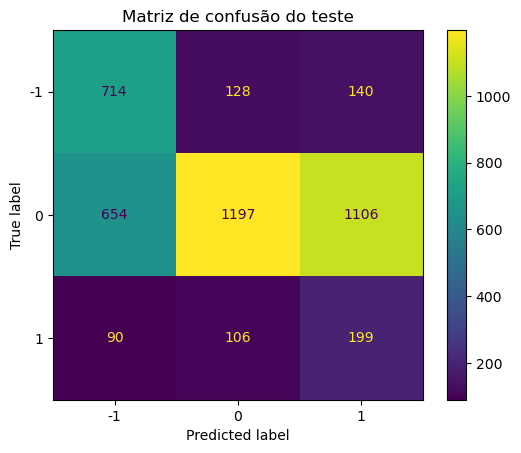

              precision    recall  f1-score   support

          -1     0.4897    0.7271    0.5852       982
           0     0.8365    0.4048    0.5456      2957
           1     0.1377    0.5038    0.2163       395

    accuracy                         0.4868      4334
   macro avg     0.4880    0.5452    0.4490      4334
weighted avg     0.6942    0.4868    0.5246      4334



In [690]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
certos = (test_df['classe'] == test_df['Previsto4']).sum()
total = len(test_df)

matriz = confusion_matrix(test_df['classe'], test_df['Previsto4'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

from sklearn.metrics import classification_report

report = classification_report(test_df['classe'], test_df['Previsto4'], labels=classes, digits=4)
print(report)
